#Mount the shared google drive folder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

- Date of creation : 12/04/2021
- Last Update : 12/07/2021
- Aim : Implementation of Decision tree with the aim of experimenting with the following parameters:
1. preprocess (paper methodology or ours) [paper,team]
2. all_features (either MRMR seleced 8 features or all features) [MRMR_features, all_features]
3. DT_criterion (decision tree building criteria) : gini impurity or entropy [gini, entropy]
- Input : (location - DS602_project/input)
1. path(string) : path to 'DS602_project' folder.
2. TYPE(string) : name of the target variable.
3. data(dataframe) : input raw data.
- Output : (location - DS602_project/output)
1. For each preprocessing method:
    1. raw_features_preprocess(pdf): histogram for each raw feature.
    2. processed_features_preprocess(pdf) : histogram for each processed feature.
2. For each combination of the parameters mentioned above:
    1. preprocess_(all_features)_(DT_criterion)_DT(eps) : decision tree diagram  
    2. preprocess_(all_features)_(DT_criterion)_CM(eps) : confusion matrix 
3. metrics(xlsx) : Summary of metrics evaluated for each experiment

# Import modules

In [ ]:
!pip install xlsxwriter

In [ ]:
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 
import pandas as pd
import os
import sys
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import xlsxwriter
import doctest
import math
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager as fm
set([f.name for f in fm.fontManager.ttflist])
global seed
seed = 2021

import warnings
warnings.filterwarnings('ignore')

# Define 'DS602_project' folder path and Target feature

In [ ]:
# give path to the 'DS602_project' folder.
path = '/content/drive/Shareddrives/Ovarian Cancer/DS602_project/'
target = 'TYPE'

# Load the data 

[link text](https:// [link text](https:// [link text](https://)))Data description
1) Raw data (supplemenatary data 1)
- 349 samples, 51 columns
- Features - 47 biomarkers, 2 non-biomarkers (Age, Menopause), TYPE (target : 1-BOT and 0-OC), SUBJECT_ID.

2) Raw trainining data (supplementary data 4) (pick first 235 rows)
- 235 samples, 51 columns
- Features - 47 biomarkers, 2 non-biomarkers (Age, Menopause), TYPE (target : 1-BOT and 0-OC), SUBJECT_ID.

3) Imputed trainining data (supplementary data 3)(pick first 235 rows)
- 235 samples, 49 columns
- Features - 46 biomarkers (CA72-4 removed, high missing rate), 2 non-biomarkers (Age, Menopause), TYPE (target : 1-BOT and 0-OC).
- Missing values handled.
- All numeric columns
- Outlier handled.

In [ ]:
# loading raw data
data = pd.read_excel(os.path.join(path,'input/Supplementary data 1.xlsx'))
data.head()

,SUBJECT_ID,AFP,AG,Age,ALB,ALP,ALT,AST,BASO#,BASO%,BUN,Ca,CA125,CA19-9,CA72-4,CEA,CL,CO2CP,CREA,TYPE,DBIL,EO#,EO%,GGT,GLO,GLU.,HCT,HE4,HGB,IBIL,K,LYM#,LYM%,MCH,MCV,Menopause,Mg,MONO#,MONO%,MPV,Na,NEU,PCT,PDW,PHOS,PLT,RBC,RDW,TBIL,TP,UA
0,1,3.58\t,19.36,47,45.4,56.0,11.0,24.0,0.01,0.30,5.35,2.48,15.36\t,36.48\t,6.42,1.40,107.4,19.9,103.0,0,2.0,0.04,1.00,16.0,28.5,4.67,0.273,NaN,89.0,3.5,5.36,0.65,16.8,33.7,103.4,0,0.78,0.22,5.70,11.70,141.3,76.2,0.09,13.4,1.46,74,2.64,13.7,5.5,73.9,396.4
1,2,34.24\t,23.98,61,39.9,95.0,9.0,13.0,0.02,0.30,3.21,2.62,2444.00\t,19.98\t,NaN,2.46,100.1,22.3,45.0,0,2.6,0.04,0.50,13.0,32.1,10.50,0.417,934.10,128.0,4.2,4.38,1.27,17.2,26.2,85.3,1,0.82,0.41,5.50,10.00,142.0,76.5,0.30,11.2,1.09,304,4.89,12.7,6.8,72.0,119.2
2,3,1.50\t,18.40,39,45.4,77.0,9.0,18.0,0.03,0.60,3.80,2.57,56.08\t,12.18\t,NaN,0.77,102.6,22.2,48.0,0,4.7,0.03,0.60,10.0,32.5,4.64,0.391,47.56,131.0,10.1,4.30,1.10,23.7,28.4,84.6,0,1.00,0.25,5.40,11.40,138.9,69.7,0.13,15.2,0.97,112,4.62,12.0,14.8,77.9,209.2
3,4,2.75,16.60,45,39.2,26.0,16.0,17.0,0.05,0.74,5.27,2.35,2555,18.41,131.60,0.82,103.2,24.0,65.7,0,2.9,0.00,0.07,17.0,26.9,4.76,0.372,853.50,123.0,8.0,4.70,1.73,27.2,30.6,92.6,1,1.11,0.42,6.55,7.38,139.1,65.5,0.25,17.4,1.25,339,4.01,14.6,10.9,66.1,215.6
4,5,2.36,19.97,45,35.0,47.0,21.0,27.0,0.01,0.10,4.89,2.48,1391,11.15,NaN,0.42,99.6,26.2,70.3,0,2.2,0.11,1.60,24.0,31.5,4.07,0.383,404.90,122.0,3.1,4.77,1.98,28.8,27.7,87.0,0,1.08,0.69,10.00,10.40,141.0,59.5,0.28,11.9,0.94,272,4.40,13.4,5.3,66.5,206.0


In [ ]:
#@title
# finding features apart from biomarkers
features = pd.read_excel(os.path.join(path,'input/Supplementary data 2.xlsx')).iloc[:,0]
non_biomarkers = set(data.columns)-set(features)
# The data has 47 biomarkers and 2 non-biomarkers as features : Age, Menopause. 
# Target column is 'TYPE', where 1 is benign ovarian tumor (BOT) and 0 is ovarian cancer.
# Along with SUBJECT_ID, we have total 51 columns.


# Data Preprocessing

In [ ]:
def remove_univalue_columns(df):
    """
    Removing columns with only one value, since it won't have any effect on our predictions

    >>> x = pd.DataFrame({
    ...     'unique': np.ones(100),
    ...     'distinct': np.random.rand(100)
    ... })
    >>> remove_univalue_columns(x)
    >>> x.columns
    Index(['distinct'], dtype='object')
    """
    cols_1_value = []
    for i in df.columns:
        if len(df[i].unique())==1:
            cols_1_value.append(i)
    df.drop(columns = cols_1_value,inplace = True)

    # return df


In [ ]:
def convert(temp):
    """
    Function to convert object column (only applicable on the given data) to remove any non numeric data.
    
    :param temp: str
    :return: str

    >>> convert("3.58\t")
    '3.58'

    >>> convert("22.456")
    '22.456'
    >>> convert(123)
    123
    >>> convert(float("nan"))
    nan

    """

    if isinstance(temp,str):
        return re.sub('[^0-9.]',"",temp)        
    return temp

 

In [ ]:
def convert_columns_to_numeric(df):
    """
    Dealing with object type column with a mixture string, int and float. We convert it into single data type - float.

    >>> df = pd.DataFrame({'col': ["abc1","122.23","12abc.","abc12"]})
    >>> list(convert_columns_to_numeric(df)['col'])
    [1.0, 122.23, 12.0, 12.0]

    """
    object_cols = list(df.select_dtypes(include = ['object']).columns)
    other_cols = list(df.select_dtypes(exclude = ['object']).columns)
    if len(object_cols)!=0:
        # There are 3 such columns : AFP, CA125, CA19-9. 
        # Can use the na_action to ignore nan
        df2 = df[object_cols].applymap(convert).astype('float')
        df = pd.concat([df[other_cols],df2],axis=1)
    return df

In [ ]:
def remove_na_columns(df,threshold):
    """
    Removing columns with more than threshold% NAs. (MAR - Missing at Random)
    Also analyse data and remove unwanted columns. i.e: SUBJECT_ID

    >>> df = pd.DataFrame({
    ...     'delete': [11,np.nan,np.nan,15,18],
    ...     'retain': [12,5,np.nan,1,5],
    ...     'SUBJECT_ID' : [1,1,1,1,1]
    ... })
    >>> list(remove_na_columns(df,0.25))
    ['retain']
    """
    remove_cols_na = list(df.columns[(df.isna().sum()>(int(df.shape[0]*threshold)))])
    # we get 2 such columns : NEU, CA72-4.
    df = df.drop(columns = remove_cols_na).copy()
    df.drop(columns = ["SUBJECT_ID"],inplace = True)
    return df

In [ ]:
def fillna_impute(df,impute_method):
    """
    >>> df = pd.DataFrame({
    ...     'retain': [12,5,np.nan,1,5],
    ... })
    >>> df = fillna_impute(df,'mean')
    >>> print(df.isna().sum().sum())
    0
    """
    if impute_method == 'mean':
        return df.fillna(df.mean())
    elif impute_method == 'median':
        return df.fillna(df.median())
    elif impute_method == 'mode':
        return df.fillna(df.mode().iloc[0,:])
    

In [ ]:
def plot_features(df,path, name):   
    pdf = PdfPages(os.path.join(path,'output/'+name+'.pdf'))
    
    for i in range(df.shape[1]):
        fig = plt.figure()
        plt.hist(df.iloc[:,i])
        plt.title('Mean : '+str(round(df.iloc[i,:].mean(),4)) +', Std : '+str(round(df.iloc[i,:].std(),4))+'. Skewness : '+str(round(df.iloc[i,:].skew(),4)))
        plt.suptitle(df.columns[i])
        pdf.savefig(fig)
        if(show_graphs):
            plt.show()
        plt.close()
    
    pdf.close()

In [ ]:
def plot_features_2(df):

    ds1_hist_all = df
    ds1_hist_OC = df[df['TYPE']==0]
    ds1_hist_BOT = df[df['TYPE']==1]

    n_bins = 15
    histsize = 30.0
    dfCols = df.shape[1] #columns in df
    cols = 3
    rows = math.ceil(dfCols/cols) #autosize rows of subplots
    colors = ['blue', 'red', 'green']
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=[histsize, 3*histsize])
    # print(len(df.columns))
    #Loop through each column, plot subplots:
    ds1colNum = 0
    for i in range(rows): #subplot rows
        for j in range(cols):

            if (ds1colNum < len(df.columns)) and (not df.columns[ds1colNum] is None): #more subplots than columns in DF
                x_OC = ds1_hist_OC.iloc[:,ds1colNum]
                x_BOT = ds1_hist_BOT.iloc[:,ds1colNum]
                x_all = ds1_hist_all.iloc[:,ds1colNum]
                
                axs[i, j].hist([x_all], stacked=False, bins=n_bins, color=colors[2])
                axs[i, j].hist([x_BOT, x_OC], stacked=False, bins=n_bins, color=colors[0:2])
                ftrTitle = df.columns[ds1colNum]

                
                # axs[i, j].set_xlabel(unit, loc='right')
                axs[i, j].set_title(ftrTitle + '\n' + 'Mean : '+ str(round(df.iloc[:,ds1colNum].mean(),4)) + ', Std : ' + str(round(df.iloc[:,ds1colNum].std(),4))+'. Skewness : '+ str(round(df.iloc[:,ds1colNum].skew(),4)))
                
                handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in colors]
                labels= ["BOT", "OC", "All"]
                axs[i, j].legend(handles, labels)

                ds1colNum += 1 #iteration tracker
    if(visualize_widget.value):
        plt.show()
    plt.close()
    

In [ ]:
def data_preprocessing_paper(df,path,name,impute_method):
    """
    The function handles the following tasks:
        1) check if dataframe has data.
        2) remove columns with only one value.
        3) Handle object columns with mixed data types.
        4) Remove SUBJECT_ID and columns with high missing rate. (CA72-4)
        5) Impute missing data using mean.
    """

    if df.shape[0]==0:
        print("Data not available!")
        return
      
    remove_univalue_columns(df)
    # no such column exists
    
    df = convert_columns_to_numeric(df)

    df = remove_na_columns(df,0.5)
    
    # Plotting the features to understand the distributions
    # plot_features(df,path,'raw_features_'+name)
    plot_features_2(df,path,'raw_features_'+name)
    
    # 5) To handle missing values, we impute it with mean, as mentioned in the paper
    df_preprocessed = fillna_impute(df,impute_method)
    
    
    # Plotting the features
    # plot_features(df_preprocessed,path,'processed_features_'+name)
    plot_features_2(df_preprocessed,path,'processed_features_'+name)
    
    return df_preprocessed

In [ ]:
def data_preprocessing_team(df,path,name,impute_method):
    """
    The function handles the following tasks:
        1) check if dataframe has data.
        2) remove columns with only one value.
        3) Handle object columns with mixed data types.
        4) Remove SUBJECT_ID and columns with high missing rate. (CA72-4 and NEU)

        The function handles the following tasks:
        1) check if dataframe has data.
        2) remove columns with only one value.
        3) Handle object columns with mixed data types.
        4) Remove SUBJECT_ID and columns with high missing rate. (CA72-4)
        5) Impute missing data using mean.

    >> df = pd.DataFrame({
    ...     
    >> df_preprocessed = data_preprocessing_paper(df,'/content/drive/Shareddrives/Ovarian Cancer/DS602_project/','paper','mean')
    >> len(df_preprocessed.columns)
    2
    >> df_preprocessed.isna().sum().sum()
    0
    >> len(df_preprocessed.select_dtypes(exclude = ['float','int']).columns)
    0
    
    """
    if df.shape[0]==0:
        print("Data not available!")
        return
      
    remove_univalue_columns(df)
    # no such column exists
    
    df = convert_columns_to_numeric(df)

    df = remove_na_columns(df,0.25)
    
    
    # Plotting the features to understand the distributions
    # plot_features(df,path,'raw_features_'+name)
    plot_features_2(df,path,'raw_features_'+name)
    
    # 5) To handle missing values, we impute it either with a constant, mean, median or mode of the respective column.
    # Note : Interpolation is used for handling missing values for temporal data. For non-temporal dataset, we impute for now.
    # If data is skewed, we replace NAs with median, else we use mean.
    # In our data, many features are skewed. Hence, we decide to replace missing values with median!
    df_preprocessed = fillna_impute(df,impute_method)
    

    #Alternate method is using surrogate tree splitting, mode etc.
    
    # Plotting the features
    # plot_features(df_preprocessed,path,'processed_features_'+name)
    plot_features_2(df_preprocessed,path,'processed_features_'+name)
    # Remove outliers ----?
    
    return df_preprocessed

# Building a Preliminary Decision Tree based on Gini Impurity

In [ ]:
#@title
def preliminary_DT(X,y,depth,cross_val,DT_criterion,path='',name=''):
    
    model = DecisionTreeClassifier(random_state=seed,criterion= DT_criterion,max_depth = depth)
    model_fit = model.fit(X,y)
    
    # if cross_val ==False:        
    # fig = plt.figure()
    # plot_tree(model_fit,rounded=True, filled=True, class_names=["OC", "BOT"],feature_names=X.columns)
    # plt.savefig(os.path.join(path,'output/'+name+'_DT.eps'),format='eps',bbox_inches="tight")
    # plt.show()
    # plt.close()    

    
    return model,model_fit

# Evaluating the model based on the following parameters :
### 1) Sensitivity (Recall)
### 2) Specificity
### 3) Positive Predicitve Value (Precision)
### 4) Negative Predictive Value 
### 5) Accuracy

In [ ]:

def calculate_metrics(y_actual,y_predicted, worksheet,row):
    """
    Function that caculated confusion matrix, sensitivity(recall), specificity, positive predictive value, negative predictive value and accuracy.
    """
    tn, fp, fn, tp = confusion_matrix(y_actual,y_predicted).ravel()
    
    # Sensitivity (Recall)
    sensitivity = round(tp/(tp+fn),3)
    
    # Specificity 
    specificity = round(tn/(tn+fp),3)
    
    # Positive predictive value (precision)
    positive_predictive_value = round(tp/(tp+fp),3)
    
    # Negative predictive value (precision)
    negative_predictive_value = round(tn/(tn+fn),3)
    
    # F1 score
    f1_score = 2*positive_predictive_value*sensitivity/(positive_predictive_value+sensitivity)
    
    # Accuracy : No. of correct predictions out of total
    accuracy = round((tp+tn)/(tp+tn+fp+fn),3)
    
    metrics=[tp,fp,fn,tn,sensitivity,specificity,positive_predictive_value,negative_predictive_value,
            f1_score,accuracy]
    
    print(metrics)

    if(not(worksheet==None or row==None)):
        # saving the values in the excel
        for i in range(1,11):
            worksheet.write(row,i,metrics[i-1])
    
    return

In [ ]:
def run_cross_validation_on_trees(X, y, tree_depths,splits,c, scoring='accuracy'):
    """
    Function for fitting trees of various depths on the training data using cross-validation
    """
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    tree_models = []
    for depth in tree_depths:
        skf = StratifiedKFold(n_splits=splits,shuffle=True, random_state=seed)
        tree_model,model_fit = preliminary_DT(X,y,depth,True,c)
        cv_scores = cross_val_score(tree_model, X, y, cv=skf, scoring=scoring)
        tree_models.append(tree_model)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
        
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return tree_models,cv_scores_mean, cv_scores_std, accuracy_scores

In [ ]:
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title,path,name):
    """
    Function for plotting cross-validation results
    """
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    #ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    ax.set_rasterized(True)
    fig.savefig(os.path.join(path,'output/'+name+'_crossval.eps'),format='eps',bbox_inches="tight")
    plt.show()
    plt.close(fig)

# Defining driver function

In [ ]:
def main():

    
    #to check if all modules are getting imported or not.
    try:
        sys.version
    except ImportError as error:
        # Output expected ImportErrors.
        print(error.__class__.__name__ + ": " + error.message)


    # checking if the parameters and path location are defined or not
    try: #if data is not given
        data
    except NameError:
        print("Missing data!")
        return
    try: #if data is not given
        path
    except NameError:
        print("Path to 'DS602_project' folder is not mentioned!")
        return
    try: #if target column is not given
        target
    except NameError:
        print("Target feature not mentioned!")
        return


    finally:         
        
        #hyperparameters
        #defining names to save output
        num_experiments = 8 # no. of experiments
        feature_all =[False,True] # whether to use all features or only 8 features (selected by MRMR in the paper).
        
        # defininig criteria for DT.
        DT_criterion = ["gini","entropy"] 
        impute_method = ["mean","median","mode"]

        shuffle = [False,True] # Should we shuffle the dataset before train_test split
        stratified_k_cross_validation = [False,True]

        splits = 5 # for stratified k-cross validation
        tree_depths = range(1,21)
        training_data_size = 235

        
        # Create a workbook and add a worksheet to directly store metrics results
        workbook = xlsxwriter.Workbook(os.path.join(path,'output/metrics.xlsx'))
        worksheet = workbook.add_worksheet()
        worksheet.write(0,0,'Experiment')
        worksheet.write(0,1,'TP')                                           
        worksheet.write(0,2,'FP')
        worksheet.write(0,3,'FN')                                          
        worksheet.write(0,4,'TN')
        worksheet.write(0,5,'Sensitivity (Recall)')                                            
        worksheet.write(0,6,'Specificity')
        worksheet.write(0,7,'Positive Predictive Value')  
        worksheet.write(0,8,'Negative Predictive Value')        
        worksheet.write(0,9,'F1 score')  
        worksheet.write(0,10,'Accuracy')
        worksheet.write(0,11,'Tree depth')
        worksheet.write(0,12,'Stratified Cross Validation result')
        row = 1

                      

        for k in stratified_k_cross_validation: # enable or disable startified k-cross validation
            if(not(k)):
                tree_depths = [2]
            for i in impute_method: # run across different fill na criteria        
                for c in DT_criterion: # run across different criterias for DT
                    for f in feature_all : # run for experiment with either 8 or all features.                        
                        for s in shuffle: # enable or disable data shuffling                    

                            name = 'Teal'
                            if f:
                                name += '_all_features_'
                            else:
                                name += '_MRMR_features_'
                            
                            name += '_'+c+'_'
                            name += '_'+i+'_'

                            if s:
                                name += '_shuffle'
                            
                            if k:
                                name += '_stratified_k_cross'



                            # calling the data preprocessing function
                            if f==False and c=='gini' and i=='mean' and k==False and s==False:
                                data_processed = data_preprocessing_paper(data,path,'Original Paper',i)

                                # our data now 349 rows and 49 columns (46 biomarkers (CA72-4 removed), 2 non-biomarkers and target column (TYPE)).
                            else:
                                data_processed = data_preprocessing_team(data,path,'Team_',i)                                
                                # our data now 349 rows and 48 columns (45 biomarkers (CA72-4 and NEU removed), 2 non-biomarkers and target column (TYPE)).

                            # Format the data and define the name to save decision tree, confusion martix and values of various metrics.
                            # a) Divide data into dependent and independent variables
                            if f==False:
                                X = data_processed[['Menopause', 'Age', 'AFP', 'CEA', 'HE4', 'CA19-9', 'LYM%', 'CO2CP']].copy()                                
                            else:
                                X = data_processed.drop(['TYPE'],axis=1).copy()                                
                        

                            y = data_processed[target].copy()
                            
                            # b) split  the data into train and test 
                            X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=seed,shuffle=s,train_size=training_data_size)
                            
                            # c) find the best tree depth based on Stratified kcross validation on train data.
                            tree_models, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, tree_depths,splits,c)
                            idx_max = sm_cv_scores_mean.argmax()
                            sm_best_tree_depth = tree_depths[idx_max]
                            sm_best_tree_model = tree_models[idx_max]
                            sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
                            sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
                            print_result = 'The tree achieves the best mean cross-validation accuracy '+str(round(sm_best_tree_cv_score*100,5))+' +/-'+ str(round(sm_best_tree_cv_score_std*100, 5))+' % on training dataset'

                            plot_tree(sm_best_tree_model,rounded=True, filled=True, class_names=["OC", "BOT"],feature_names=X_train.columns)
                            plt.show()
                            plt.close()
                            
                            # plotting accuracy
                            plot_cross_validation_on_trees(tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                                    'Accuracy per decision tree depth on training data',path,name)
                        
                            print(name)

                            # d) Build preliminary decision tree based on DT criteria.
                            # To achieve the same paramters as the paper, we first train the model using 8 features selected by MRMR and then
                            # backtrack to find the DT parameter values.
                            # We find that the paper is using the default values for the DT with depth of tree as 2 and criterion as gini.
                            model,model_fit = preliminary_DT(X_train,y_train,sm_best_tree_depth,k,c,path,name) 

                            # e) Evaluating the model and saving the metrics values
                            worksheet.write(row,0,name)                               
                            calculate_metrics(y_test,model_fit.predict(X_test),worksheet,row)
                            worksheet.write(row,11,sm_best_tree_depth)   
                            worksheet.write(row,12,print_result)   

                            # Plotting the confusion matrix
                            fig = plt.figure()
                            # plot_confusion_matrix(model_fit, X_test, y_test, display_labels=["OC", "BOT"])
                            y_pred = model.predict(X_test)
                            ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["OC", "BOT"])
                            plt.savefig(os.path.join(path,'output/'+name+'_CM.eps'),format='eps',bbox_inches="tight")
                            plt.show()
                            plt.close()
                                                            
                            # update row variable to go to the next row in excel
                            row+=1        
                            print()
                                                    
        workbook.close()
        return 

In [ ]:
def gui_model_main(b):

    print('Generating! Please Wait.....')
    splits = 5 # for stratified k-cross validation
    tree_depths = range(1,21)
    training_data_size = 235

    # show_graphs = visualize_widget.value
    # print('1:',show_graphs)

    name = 'Teal'
    if features_widget.value == 'All':
        name += '_all_features_'
        f=True
    else:
        name += '_MRMR_features_'
        f=False

    name += '_'+dt_criteria_widget.value+'_'
    if dt_criteria_widget.value == 'Gini':        
        c = 'gini'
    else:
        c = 'entropy'

    name += '_'+impute_widget.value+'_'
    if impute_widget.value == 'Mean':        
        i = 'mean'
    elif impute_widget.value == 'Median':
        i = 'median'
    else:
        i = 'mode'

    s = shuffle_widget.value
    if shuffle_widget.value:
        name += '_shuffle'
    
    k = stratified_widget.value
    if stratified_widget.value:
        name += '_stratified_k_cross'
    else:
        if(not(k)):
            tree_depths = [2]



    # calling the data preprocessing function
    if f==False and c=='gini' and i=='mean' and k==False and s==False:
        data_processed = data_preprocessing_paper(data,path,'Original Paper',i)
        # our data now 349 rows and 49 columns (46 biomarkers (CA72-4 removed), 2 non-biomarkers and target column (TYPE)).
    else:
        data_processed = data_preprocessing_team(data,path,'Team_',i)                                
        # our data now 349 rows and 48 columns (45 biomarkers (CA72-4 and NEU removed), 2 non-biomarkers and target column (TYPE)).

    # Format the data and define the name to save decision tree, confusion martix and values of various metrics.
    # a) Divide data into dependent and independent variables
    if f==False:
        X = data_processed[['Menopause', 'Age', 'AFP', 'CEA', 'HE4', 'CA19-9', 'LYM%', 'CO2CP']].copy()                                
    else:
        X = data_processed.drop(['TYPE'],axis=1).copy()                                


    y = data_processed[target].copy()
    
    # b) split  the data into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=seed,shuffle=s,train_size=training_data_size)
    
    # c) find the best tree depth based on Stratified kcross validation on train data.
    tree_models, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, tree_depths,splits,c)
    idx_max = sm_cv_scores_mean.argmax()
    sm_best_tree_depth = tree_depths[idx_max]
    sm_best_tree_model = tree_models[idx_max]
    sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
    sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
    print_result = 'The tree achieves the best mean cross-validation accuracy '+str(round(sm_best_tree_cv_score*100,5))+' +/-'+ str(round(sm_best_tree_cv_score_std*100, 5))+' % on training dataset'

    plot_tree(sm_best_tree_model,rounded=True, filled=True, class_names=["OC", "BOT"],feature_names=X_train.columns)
    plt.show()
    plt.close()

    # plotting accuracy
    plot_cross_validation_on_trees(tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
            'Accuracy per decision tree depth on training data',path,name)

    print(name)

    # d) Build preliminary decision tree based on DT criteria.
    # To achieve the same paramters as the paper, we first train the model using 8 features selected by MRMR and then
    # backtrack to find the DT parameter values.
    # We find that the paper is using the default values for the DT with depth of tree as 2 and criterion as gini.
    model,model_fit = preliminary_DT(X_train,y_train,sm_best_tree_depth,k,c,path,name) 

    # e) Evaluating the model and saving the metrics values                        
    calculate_metrics(y_test,model_fit.predict(X_test),None,None)

    # Plotting the confusion matrix
    fig = plt.figure()
    # plot_confusion_matrix(model_fit, X_test, y_test, display_labels=["OC", "BOT"])
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["OC", "BOT"])
    plt.savefig(os.path.join(path,'output/'+name+'_CM.eps'),format='eps',bbox_inches="tight") 
    plt.show()   
    plt.close()                                    
    print()

ToggleButtons(description='Shuffle', options=(True, False), value=True)

ToggleButtons(description='Impute', options=('Mean', 'Median', 'Mode'), value='Mean')

ToggleButtons(description='Stratified', options=(True, False), value=True)

ToggleButtons(description='DT Criteria', options=('Entropy', 'Gini'), value='Entropy')

ToggleButtons(description='Features', options=('All', 'MRMR'), value='All')

ToggleButtons(description='Visualize', options=(True, False), value=True)

Button(description='Generate!', style=ButtonStyle())

Output()

Generating! Please Wait.....


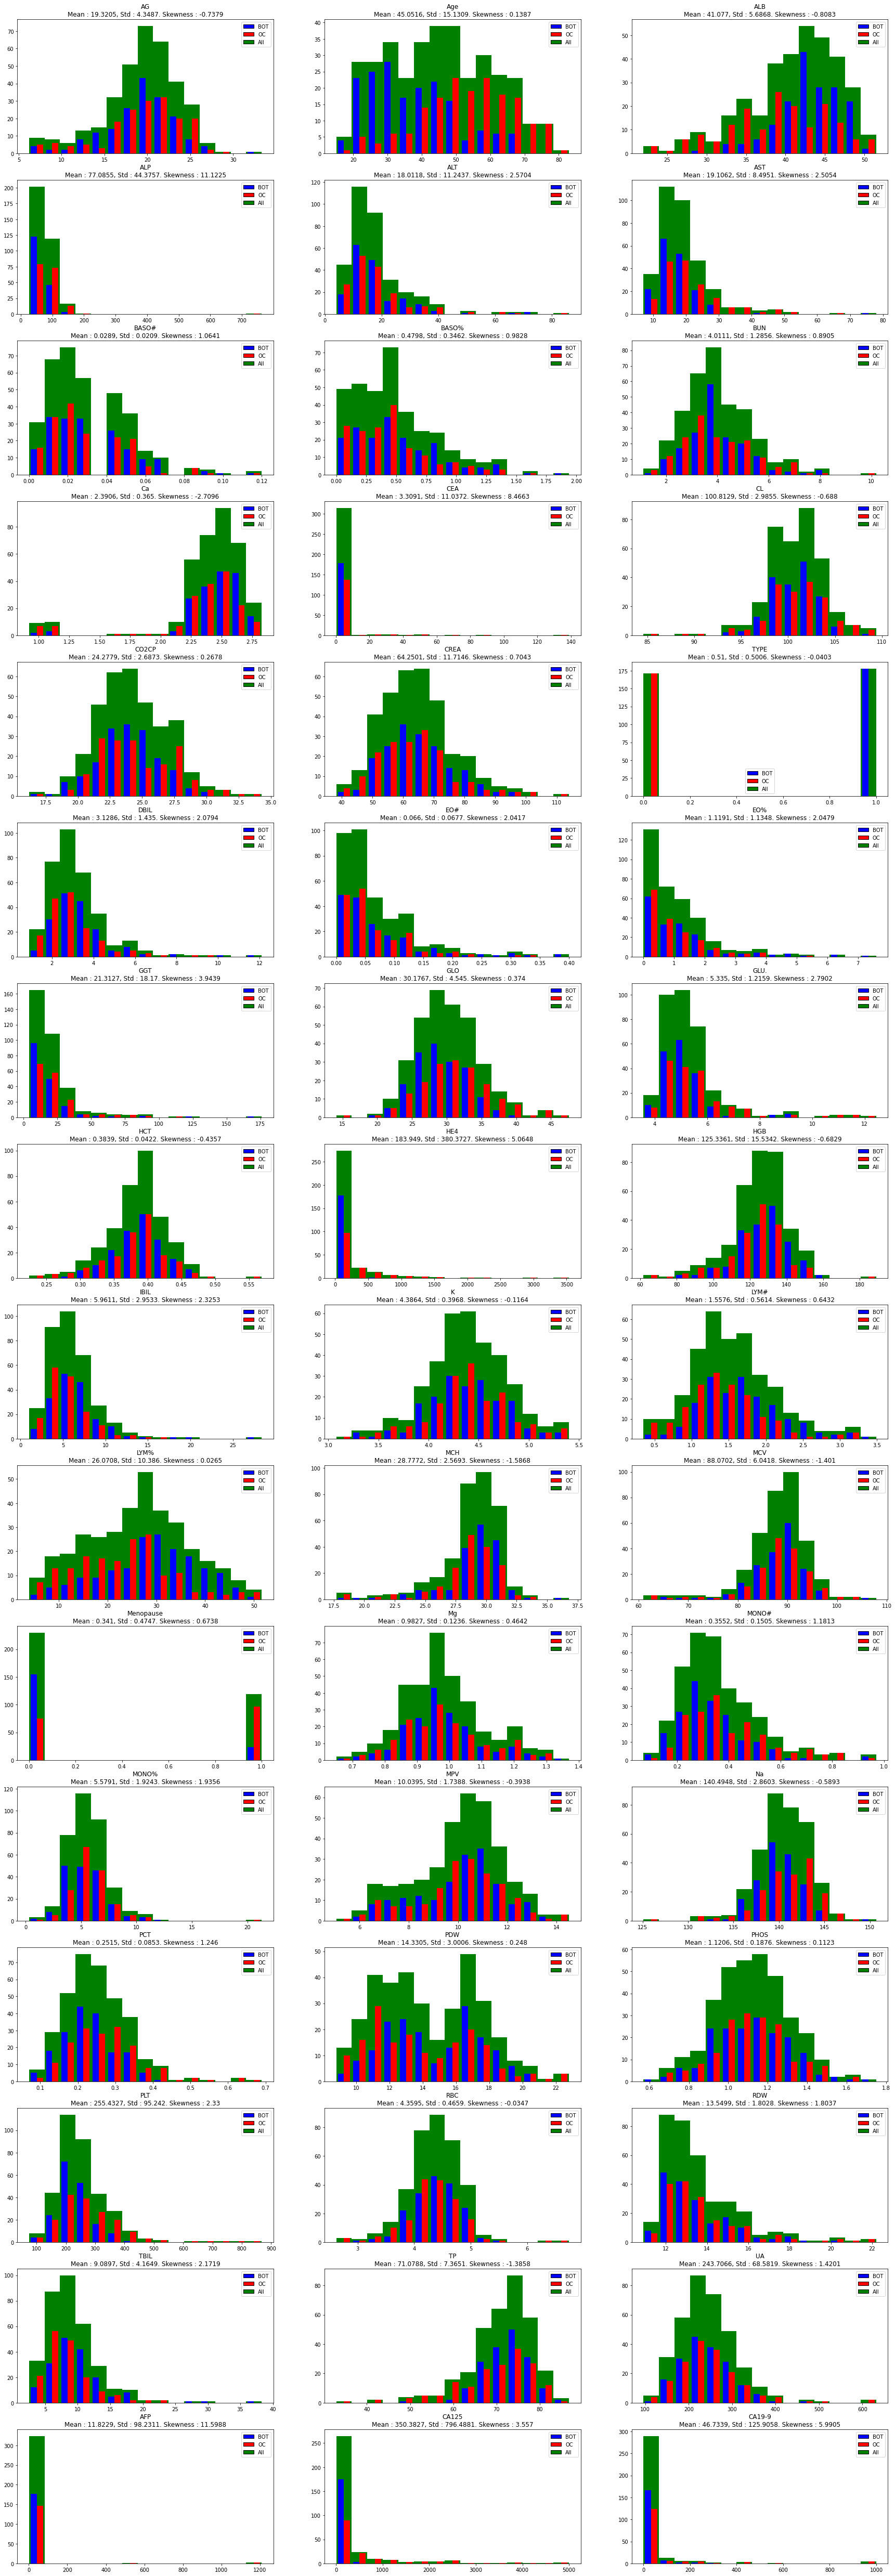

In [ ]:
import ipywidgets as widgets
from IPython.display import display

shuffle_widget = impute_widget = widgets.ToggleButtons(
    options=[True,False],
    description='Shuffle',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

display(shuffle_widget)

impute_widget = widgets.ToggleButtons(
    options=['Mean', 'Median', 'Mode'],
    description='Impute',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

display(impute_widget)

stratified_widget = widgets.ToggleButtons(
    options=[True,False],
    description='Stratified',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

display(stratified_widget)


dt_criteria_widget = widgets.ToggleButtons(
    options=['Entropy','Gini'],
    description='DT Criteria',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

display(dt_criteria_widget)

features_widget = widgets.ToggleButtons(
    options=['All','MRMR'],
    description='Features',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

display(features_widget)
print()
visualize_widget = widgets.ToggleButtons(
    options=[True,False],
    description='Visualize',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

visualize_widget.value = True
display(visualize_widget)

button = widgets.Button(description="Generate!")
output = widgets.Output()

display(button, output)

button.on_click(gui_model_main)
# doctest.testmod()


In [ ]:
doctest.testmod()
# main()

TestResults(failed=0, attempted=14)